In [1]:
import subprocess
import ltspice
import numpy as np
import matplotlib.pyplot as plt

In [164]:
def gen_noise(duration = 200e-3, sampling_rate = 10e6, noise_bw = 80e3, mean = 0.0, std_dev = 1):
    num_samples = int(duration * noise_bw)
    # Generate time array
    time = np.linspace(0, duration, num_samples)
    # Generate white Gaussian noise
    noise = np.random.normal(mean, std_dev, num_samples)
    # Zero-hold the data to match the sampling rate
    hold_factor = int(sampling_rate / noise_bw)
    held_time = np.linspace(0, duration, int(duration*sampling_rate))
    held_noise = np.repeat(noise, hold_factor)
    # Combine time and noise into a single array
    data = np.column_stack((held_time, held_noise))
    return data

In [66]:
def gen_TRAG_pulse(duration = 200e-3, sampling_rate = 10e3,Vreset = -1,treset = 50e-3,Vpulse = 0.2,tpulse = 80e-3):
    num_samples = int(duration * sampling_rate)
    # Generate time array
    time = np.linspace(0, duration, num_samples)
    V_trag = np.ones(num_samples)*Vreset
    V_trag[0:int(treset*sampling_rate)] = Vreset
    V_trag[int(treset*sampling_rate):int((treset+tpulse)*sampling_rate)] = Vpulse
    data = np.column_stack((time, V_trag))
    return data

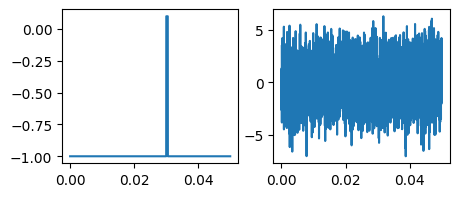

In [182]:
trag_pulse = gen_TRAG_pulse(duration = 50e-3, sampling_rate = 10e6,Vreset = -1,treset = 30e-3,Vpulse = 0.1,tpulse = 500e-6)
noisedata  = gen_noise(duration = 50e-3, sampling_rate = 10e6, noise_bw = 80e3, mean = 0.0, std_dev = 2)

plt.figure(figsize=(5,2))
plt.subplot(1,2,1); plt.plot(trag_pulse[:,0],trag_pulse[:,1])
plt.subplot(1,2,2); plt.plot(noisedata[:,0],noisedata[:,1])


In [183]:
# Path to LTSpice executable
ltspice_exe = 'C:\\Users\\manik\\AppData\\Local\\Programs\\ADI\\LTspice\\LTspice.exe'

def RunLTsimulation(netlist_file):
    # Run LTSpice simulation
    subprocess.run([ltspice_exe, '-b', netlist_file], check=True)

In [184]:
# Define the output file name
noise_data_file = 'gaussian_noise_pwl.txt'
TRAG_pulse_data_file = 'TRAG_pulse_pwl.txt'


with open(noise_data_file, 'w') as f:
    for t, v in noisedata:
        f.write(f"{t:.6e} {v:.6e}\n")
print("gaussian_noise_pwl.txt generated")

with open(TRAG_pulse_data_file, 'w') as f:
    for t, v in trag_pulse:
        f.write(f"{t:.6e} {v:.6e}\n")
print("TRAG_pulse_pwl.txt generated")


gaussian_noise_pwl.txt generated
TRAG_pulse_pwl.txt generated


In [185]:
# Path to the netlist file
netlist_file = "C:\\Drive\\FE_SR\\kramers_time_spice\\Double_well_ckt_netlist.net"

#running simulation
RunLTsimulation(netlist_file)

In [186]:
# Load the LTSpice data
lt = ltspice.Ltspice("c:\\Drive\\FE_SR\\kramers_time_spice\\Double_well_ckt_netlist.raw")
lt.parse()

# Extract data
time = lt.get_data('time')
Vin= lt.get_data('V(Mod_sig)')
Vout = lt.get_data('V(Vout)')

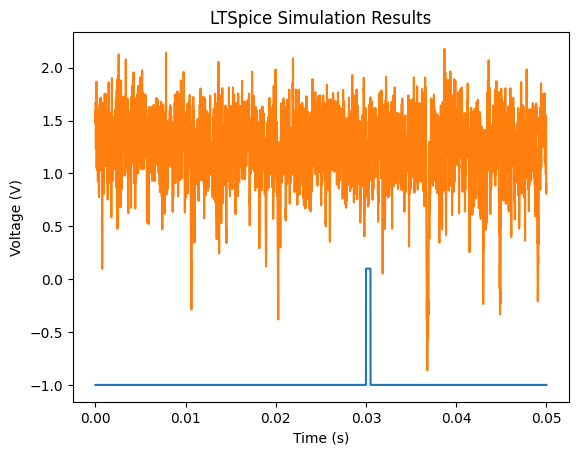

In [187]:
# Plot the results
plt.plot(time[time>0], Vin[time>0])
plt.plot(time[time>0], Vout[time>0])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('LTSpice Simulation Results')
plt.show()

In [202]:
Vout1 = Vout[(time>(30e-3)) & (time<(30e-3+500e-6))]
bit = 0
for v in Vout1:
    if v<-0.9:
        bit = 1

print(bit)

0


## Code to automate the TRAG process

* pulse width varying from 10 us to 10 ms. (9)
* bias = 0.1
* each pulse duration is tested 100 times, and bits are counted
* one iteration iteration takes around 5s
* therefor total ET: 9 X 100 X 5 = 75 min

In [221]:
t_pulse = np.array([10e-6, 100e-6, 400e-6, 500e-6, 800e-6, 1e-3, 2e-3, 5e-3, 10e-3])*0.5

bitseq_result = []
for tp in t_pulse:
    rep = 100
    #trag_pulse is generated
    trag_pulse = gen_TRAG_pulse(duration = 50e-3, sampling_rate = 10e6,Vreset = -1,treset = 30e-3,Vpulse = 0.15,tpulse = tp)
    with open(TRAG_pulse_data_file, 'w') as f:
        for t, v in trag_pulse:
            f.write(f"{t:.6e} {v:.6e}\n")
    print("TRAG_pulse_pwl.txt generated")
    bitseq = [] #reset the bit sequnce
    while(rep>0):
        rep = rep-1
        noisedata  = gen_noise(duration = 50e-3, sampling_rate = 10e6, noise_bw = 80e3, mean = 0.0, std_dev = 2)
        with open(noise_data_file, 'w') as f:
            for t, v in noisedata:
                f.write(f"{t:.6e} {v:.6e}\n")
        
        #running simulation
        RunLTsimulation(netlist_file)
        
        # Load the LTSpice data
        lt = ltspice.Ltspice("c:\\Drive\\FE_SR\\kramers_time_spice\\Double_well_ckt_netlist.raw")
        lt.parse()

        # Extract data
        time = lt.get_data('time')
        Vin= lt.get_data('V(Mod_sig)')
        Vout = lt.get_data('V(Vout)')

        Vout1 = Vout[(time>(30e-3)) & (time<(30e-3+tp))]
        bit = 0
        for v in Vout1:
            if v<-0.9:
                bit = 1
        bitseq.append(bit)
    print(bitseq)
    bitseq_result.append(bitseq)

TRAG_pulse_pwl.txt generated
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
TRAG_pulse_pwl.txt generated
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
TRAG_pulse_pwl.txt generated
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
TRAG_pulse

In [211]:
print(bitseq_result)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0], [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,

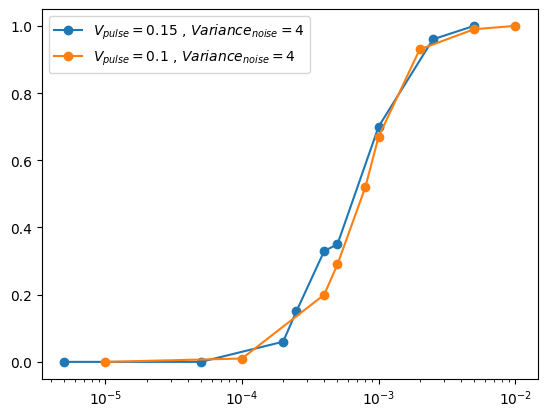

In [227]:
#probability plot
p1 = []
p2 = []
for bitseq in bitseq_result:
    p1.append(sum(bitseq)/len(bitseq))
for bitseq in bitseq_result_1:
    p2.append(sum(bitseq)/len(bitseq))


plt.plot(t_pulse,p1, "-o", label = "$V_{pulse} = 0.15$ , $Variance_{noise} = 4$")
plt.plot(t_pulse*2,p2,"-o", label = "$V_{pulse} = 0.1$ , $Variance_{noise} = 4$")
plt.xscale("log")
plt.legend()

In [219]:
bitseq_result_1 = bitseq_result